In [1]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import numpy as np 
from torch.optim import Adam 
import matplotlib.pyplot as plt 
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

/data/u_kamm_software/EEG data analysis/eeg_llm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_wave_data(num_samples=6000, seq_length=100, noise=5):
    data = []
    t = np.linspace(0, 4*np.pi, seq_length)

    for _ in range(num_samples):
        sine = np.sin(t) + noise * np.random.randn(seq_length)
        cosine = np.cos(t) + noise * np.random.randn(seq_length)

        sample = np.stack([sine, cosine], axis=1)
        data.append(sample)

    data = np.array(data)
    return data

In [3]:
# generate toy data  
data = generate_wave_data()

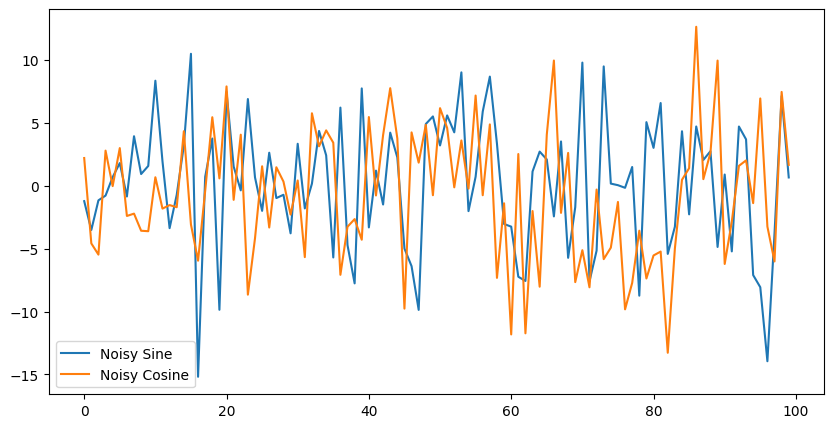

In [4]:
# plot a sample to inspect the level of noise 
s = 35 
plt.figure(figsize=(10, 5))
plt.plot(data[s, :, 0], label="Noisy Sine")
plt.plot(data[s, :, 1], label="Noisy Cosine")
plt.legend()
plt.show()

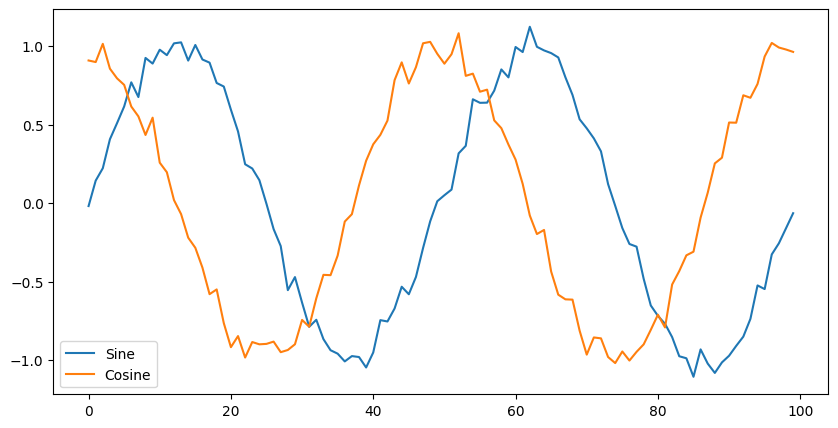

In [5]:
# plot the average to see that the clean signal can be recovered 
data_avg = np.mean(data, axis=0) 
plt.figure(figsize=(10, 5))
plt.plot(data_avg[:, 0], label="Sine")
plt.plot(data_avg[:, 1], label="Cosine")
plt.legend()
plt.show()

In [6]:
def split_data(data, test_size=0.2, random_state=None):
    X_train, y = train_test_split(data, test_size=test_size, random_state=random_state)
    return X_train, y

In [7]:
# split the data into training and test set 
X_train, y = split_data(data, random_state=42)

In [8]:
def create_data_loaders(X_train, X_test, batch_size=16, shuffle=True):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    train_dataset = TensorDataset(X_train)
    test_dataset = TensorDataset(X_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader 

In [9]:
# batch the data 
train_loader, test_loader = create_data_loaders(X_train, y)

In [10]:
def split_past_future(batch, num_future_points=10):
    past_values = batch[:, :-num_future_points, :]
    future_values = batch[:, -num_future_points:, :]
    return past_values, future_values

In [11]:
# define the configuration of the model 
config = TimeSeriesTransformerConfig(
    prediction_length=10,  # length of the future values to predict
    context_length=89,  # length of the past values to use
    num_time_features=1, # number of time features
    encoder_layers=2,  # number of transformer layers in the encoder
    decoder_layers=2,  # number of transformer layers in the decoder
    d_model=32,  # dimension of the model
    n_heads=4,  # number of attention heads
    input_size=2, # size of the input 
    lags_sequence=[1], # sequence of lags 
    )

# initialize the model 
model = TimeSeriesTransformerForPrediction(config)

In [12]:
# define the prediciton lenght
num_future_points = 10 
# Initialize optimizer
optim = Adam(model.parameters(), lr=1e-3)
# store the params 
params_lst = []
# Define the number of epochs 
num_epochs = 20

# iterate over all epochs 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0 
    epoch_params = []

    # iterate over each batch 
    for batch in train_loader: 
        past_values, future_values = split_past_future(batch[0], num_future_points=num_future_points)

        batch = {
            "past_values": past_values,  # (batch_size, input_length, input_size)
            "future_values": future_values,  # (batch_size, prediction_length, input_size)
            "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  # (batch_size, seq_length, 1)
            "past_observed_mask": torch.ones_like(past_values),  # (batch_size, seq_length, input_size)
            "future_observed_mask": torch.ones_like(future_values), # (batch_size, prediciton_lenght, input_size)
            "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + num_future_points).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  # (batch_size, prediction_length, 1)
            "return_dict": True
        }

        # Forward pass
        outputs = model(
            past_values=batch["past_values"],
            past_time_features=batch["past_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            future_observed_mask=batch["future_observed_mask"],
            future_values=batch["future_values"],
            future_time_features=batch["future_time_features"],
            return_dict=batch["return_dict"]
        )

        loss = outputs.loss
        params = outputs.params
        detached_params = tuple(p.detach().cpu().numpy() for p in params)
        epoch_params.append(detached_params)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()

    params_lst.append(epoch_params)
    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/data/u_kamm_software/EEG data analysis/eeg_llm/.venv/lib/python3.9/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20, Loss: 6.1077
Epoch 2/20, Loss: 6.0852
Epoch 3/20, Loss: 6.0815
Epoch 4/20, Loss: 6.0800
Epoch 5/20, Loss: 6.0793
Epoch 6/20, Loss: 6.0786
Epoch 7/20, Loss: 6.0784
Epoch 8/20, Loss: 6.0779
Epoch 9/20, Loss: 6.0779
Epoch 10/20, Loss: 6.0775
Epoch 11/20, Loss: 6.0769
Epoch 12/20, Loss: 6.0772
Epoch 13/20, Loss: 6.0767
Epoch 14/20, Loss: 6.0767
Epoch 15/20, Loss: 6.0769
Epoch 16/20, Loss: 6.0765
Epoch 17/20, Loss: 6.0764
Epoch 18/20, Loss: 6.0762
Epoch 19/20, Loss: 6.0763
Epoch 20/20, Loss: 6.0764


In [13]:
np.array(params_lst[0]).shape

(300, 3, 16, 10, 2)

In [14]:
# define the prediction length for testing 
prediciton_length = 10
generated_predicitons = []

# iterate over each batch 
for batch in test_loader:

    past_values, future_values = split_past_future(batch[0], num_future_points=prediciton_length)

    batch = {
            "past_values": past_values,  # (batch_size, input_length, input_size)
            "future_values": future_values,  # (batch_size, prediction_length, input_size)
            "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  # (batch_size, seq_length, 1)
            "past_observed_mask": torch.ones_like(past_values),  # (batch_size, seq_length, input_size)
            "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + num_future_points).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  # (batch_size, prediction_length, 1)
        }
    
    # set the model to evaluation mode  
    model.eval()

    # create predicitons 
    with torch.no_grad():
        predictions=model.generate(
            past_values=batch["past_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"], 
            past_observed_mask=batch["past_observed_mask"], 
        )

    generated_batch_predictions = predictions.sequences
    if generated_batch_predictions.shape[0] == 16:
        generated_predicitons.append(generated_batch_predictions)

In [15]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [16]:
generated_predicitons = np.array(generated_predicitons)
num_batches = generated_predicitons.shape[0]
batch_size = generated_predicitons.shape[1]
samples = generated_predicitons.shape[2]
seq_length = generated_predicitons.shape[3]
input_size = generated_predicitons.shape[4]

generated_predicitons = generated_predicitons.reshape(num_batches * batch_size, samples, seq_length, input_size)

In [28]:
sample = 10 
mean_over_obsv = np.mean(generated_predicitons, axis=0)

In [17]:
# get the best predictions from the 100 different predictions 
target_sine = data_avg[-10:, 0]
target_cosine = data_avg[-10:, 1]
sample_idx_sine = []
sample_idx_cosine = []

for prediciton in range(generated_predicitons.shape[0]):
        mse_sine = []
        mse_cosine = []

        for sample in range(generated_predicitons.shape[1]):
            mse_sine.append(mean_squared_error(target_sine, generated_predicitons[prediciton, sample, :, 0]))
            mse_cosine.append(mean_squared_error(target_sine, generated_predicitons[prediciton, sample, :, 1]))
        
        # find the index of the best sample  
        best_pred_sine = np.argmin(np.array(mse_sine))
        best_pred_cosine = np.argmin(np.array(mse_cosine))

        sample_idx_sine.append(best_pred_sine)
        sample_idx_cosine.append(best_pred_cosine)

In [34]:
pred_mean = np.mean(generated_predicitons, axis=1)
grand_mean = np.mean(mean_over_obsv, axis=0)

In [35]:
grand_mean.shape

(10, 2)

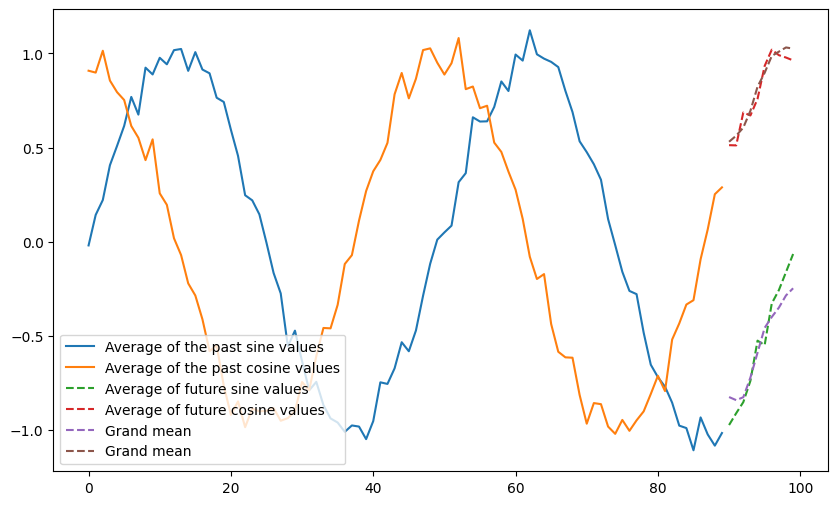

In [37]:
# define observation you want to examine 
pred = 10
pl = 10 
sample = 40
# Plot the best predictions
plt.figure(figsize=(10, 6))

# Plot the average past values
plt.plot(np.arange(len(data_avg[:-pl])), data_avg[:-pl, 0], label="Average of the past sine values")
plt.plot(np.arange(len(data_avg[:-pl])), data_avg[:-pl, 1], label="Average of the past cosine values")

# plot average over observations 
# plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), mean_over_obsv[sample, :, 0], label="Average of observations", linestyle="dotted")
# plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), mean_over_obsv[sample, :, 1], label="Average of observations", linestyle="dotted")


# Plot the past values of the observation 
# plt.plot(np.arange(len(data_avg[:-pl])), y[pred, :-pl, 0], label=f"Past sine values")
# plt.plot(np.arange(len(data_avg[:-pl])), y[pred, :-pl, 1], label=f"Past cosine values")

# Plot true future values
plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), data_avg[-10:, 0], label="Average of future sine values", linestyle='dashed')
plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), data_avg[-10:, 1], label="Average of future cosine values", linestyle='dashed')

# Plot the grand mean 
plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), grand_mean[-10:, 0], label="Grand mean", linestyle='dashed')
plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), grand_mean[-10:, 1], label="Grand mean", linestyle='dashed')

# Plot predicted future values of one sampled observation 
# plt.plot(np.arange(len(data_avg[:-10]), len(data_avg[:-10]) + 10), generated_predicitons[pred, sample_idx_sine[pred], :, 0], label=f"Predicted Sine Values of {pred + 1}th observation", linestyle='dotted')
# plt.plot(np.arange(len(data_avg[:-10]), len(data_avg[:-10]) + 10), generated_predicitons[pred, sample_idx_cosine[pred], :, 1], label=f"Predicted Cosine Values of {pred + 1}th observation", linestyle='dotted')

# Plot the mean prediction 
# plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), pred_mean[pred, :, 0], label="Average of samples for sine", linestyle="dotted")
# plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), pred_mean[pred, :, 1], label="Average of samples for cosine", linestyle="dotted")

plt.legend(loc='lower left')
plt.show()
